## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from snprop import age
from snprop import survey
from variaIa import tools
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full
from variaIa import massevol
from importlib import reload
from variaIa import stretchevol
from matplotlib.lines import Line2D
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
#smap = plt.cm.get_cmap('viridis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300),  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
df_nlowz = df_nc[df_nc['survey'] != 'low-z']

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', optio…

### Use SED fitted SNf data

In [3]:
sed = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
sed = sed.loc[sed['name'].str.contains( 'SNF|LSQ|PTF', na=False, regex=True)]
sed = sed.rename(columns={'mass': 'hostmass', 'z': 'redshifts'})
sed['hostmass_err'] = np.sqrt((sed['mass_uppererr'].values**2 +
                               sed['mass_lowerr'].values**2)/2)
snf_df_sed = df_nc[df_nc['survey'] == 'SNF']
snf_df_sed['hostmass'] = sed['hostmass'].values
snf_df_sed['hostmass_err'] = sed['hostmass_err'].values
snf_sed_nonan = snf_df_sed[~np.isnan(snf_df_sed['hostmass'])]

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
np.unique(np.isnan(snf_df_sed['hostmass']), return_counts=True)

(array([False,  True]), array([110,   4]))

In [30]:
df_fit = pd.concat([snf_sed_nonan,
                    df_nc[(df_nc['survey'] != 'SNF') &
                          (df_nc['survey'] != 'LOWZ')]])
df_fit = df_fit[df_fit['hostmass'] > 7]
df_fit_c = pd.concat([snf_sed_nonan,
                      df_c[(df_c['survey'] != 'SNF') &
                           (df_c['survey'] != 'LOWZ')]])
df_fit_c = df_fit_c[df_fit_c['hostmass'] > 7]

## Minimisation des modèles à mettre dans le _pandas_

#### SNF only

In [6]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
LIMVAL = [(0, 1), None, None, None, None,
          (0, 1), None, None, None, None]
evol4G4M4S = gen.fit(snf_sed_nonan, limits=LIMVAL)

gen.set_model('Evol3G3M4S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None, None]
evol3G3M4S = gen.fit(snf_sed_nonan, limits=LIMVAL)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None]
evol3G3M3S = gen.fit(snf_sed_nonan, limits=LIMVAL)

gen.set_model('Evol2G2M4S')
evol2G2M4S = gen.fit(snf_sed_nonan, limits=None)

gen.set_model('Evol2G2M3S')
evol2G2M3S = gen.fit(snf_sed_nonan, limits=None)

gen.set_model('Evol2G2M2S')
evol2G2M2S = gen.fit(snf_sed_nonan, limits=None)

gen.set_model('Evol1G1M2S')
evol1G1M2S = gen.fit(snf_sed_nonan, limits=None)

gen.set_model('Evol1G1M1S')
evol1G1M1S = gen.fit(snf_sed_nonan, limits=None)

mod_list = [evol1G1M1S, evol1G1M2S,
            evol2G2M2S, evol2G2M3S, evol2G2M4S,
            evol3G3M3S, evol3G3M4S, evol4G4M4S]
mod_name = ['Evol'+mod.__doc__ for mod in mod_list]

pp = PrettyPrinter()
for mod in mod_list:
    print(mod.__doc__)
    pp.pprint(mod.param)

1G1M1S
{'mu': 9.82187024818149, 'sigma': 0.7388697193607624}
1G1M2S
{'mu': 10.19404842935602,
 'sigmadown': 0.9689470171505654,
 'sigmaup': 0.4785890833911222}
2G2M2S
{'mu_1': 9.322308178865338,
 'mu_2': 10.341674380141377,
 'sigma_1': 0.5729080243370844,
 'sigma_2': 0.4997964251749382}
2G2M3S
{'mu': 10.556086116981012,
 'mu_1': 9.336756025455028,
 'sigma_1': -0.5750047677241205,
 'sigmadown': 0.696255631348485,
 'sigmaup': 0.32783825843026954}
2G2M4S
{'mu_o': 10.552854646793032,
 'mu_y': 9.246280793611174,
 'sigmad_o': 0.691540893647918,
 'sigmad_y': 0.5170665825395983,
 'sigmau_o': 0.3288749253029364,
 'sigmau_y': -0.6374655563831979}
3G3M3S
{'a': 0.9999945813320037,
 'mu_1': 9.322378781138937,
 'mu_2': 10.341529163103523,
 'mu_3': 10.038884063612668,
 'sigma_1': -0.5730405696973004,
 'sigma_2': -0.49965591995404496,
 'sigma_3': 0.01228526285763473}
3G3M4S
{'a': 0.6523796868559725,
 'mu': 10.33550196736667,
 'mu_1': 9.341989282329907,
 'mu_2': 10.560286302093251,
 'sigma_1': -0.56794

## Get proba

In [7]:
def get_proba(model):
    # return np.exp((evol2G2M3S.get_aic() - model.get_aic())/2)
    return np.exp((evol2G2M4S.get_aic() - model.get_aic())/2)

## Comparison dataframe

In [8]:
# modèles = [evol2G2M3S, evol2G2M2S,
#            evol2G2M4S, evol4G4M4S, evol3G3M4S,
#            evol3G3M3S, evol1G1M2S, evol1G1M1S]

modèles = [evol2G2M4S, #evol3G3M4S,
           evol2G2M2S, #evol4G4M4S,
           evol2G2M3S,
           #evol3G3M3S,
           evol1G1M2S, evol1G1M1S]

d_mod_comp = pd.DataFrame({'Name': [k.__doc__ for k in modèles],
                           'Fixed': [k.FIXED for k in modèles],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles],
                           '$\mathcal{L}$': [round(k.get_logl(),1) for k in modèles],
                           'AIC': [round(k.get_aic(),1) for k in modèles],
                           #'$\Delta$ AIC': [round(evol2G2M3S.get_aic()-k.get_aic(),1) for k in modèles],
                           '$\Delta$ AIC': [round(evol2G2M4S.get_aic()-k.get_aic(),1) for k in modèles],
                           'Proba': [get_proba(k) for k in modèles]
                          })

path = '../../../Data/tables/mass_comp/mass_df_snf-sed_comp-nobug'
if tools.cons.value:
    path += '_cons'
path += '.dat'
d_mod_comp.to_csv(path)

d_mod_comp

,Name,Fixed,Free param,$\mathcal{L}$,AIC,$\Delta$ AIC,Proba
0,2G2M4S,False,6,221.3,233.3,0.0,1.000000e+00
1,2G2M2S,False,4,223.9,231.9,1.4,1.973782e+00
2,2G2M3S,False,5,221.4,231.4,1.9,2.604605e+00
3,1G1M2S,True,3,259.8,265.8,-32.5,8.714756e-08
4,1G1M1S,True,2,262.4,266.4,-33.1,6.338724e-08


#### All samples combined: fiducial

In [16]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
LIMVAL = [(0, 1), None, None, None, None,
          (0, 1), None, None, None, None]
evol4G4M4S = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol3G3M4S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None, None]
evol3G3M4S = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, (5, 15), (-3, 3)]
evol3G3M3S = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol2G2M4S')
evol2G2M4S = gen.fit(df_fit, limits=None)

gen.set_model('Evol2G2M3S')
evol2G2M3S = gen.fit(df_fit, limits=None)

gen.set_model('Evol2G2M2S')
evol2G2M2S = gen.fit(df_fit, limits=None)

gen.set_model('Evol1G1M2S')
evol1G1M2S = gen.fit(df_fit, limits=None)

gen.set_model('Evol1G1M1S')
evol1G1M1S = gen.fit(df_fit, limits=None)

mod_list = [evol1G1M1S, evol1G1M2S,
            evol2G2M2S, evol2G2M3S, evol2G2M4S,
            evol3G3M3S, evol3G3M4S, evol4G4M4S]
mod_name = ['Evol'+mod.__doc__ for mod in mod_list]

pp = PrettyPrinter()
for mod in mod_list:
    print(mod.__doc__)
    pp.pprint(mod.param)

1G1M1S
{'mu': 10.115948936767756, 'sigma': 0.7936336156936603}
1G1M2S
{'mu': 10.537081210470074,
 'sigmadown': 1.0532813466253161,
 'sigmaup': 0.5175961858983374}
2G2M2S
{'mu_1': 9.626399462519458,
 'mu_2': 10.729864285411596,
 'sigma_1': 0.6954419805907796,
 'sigma_2': -0.4163648021668908}
2G2M3S
{'mu': 10.80407178236592,
 'mu_1': 9.646031067372641,
 'sigma_1': 0.7104183550835206,
 'sigmadown': -0.5122358236458001,
 'sigmaup': 0.37848640451723103}
2G2M4S
{'mu_o': 10.739040324149709,
 'mu_y': 9.341005384239379,
 'sigmad_o': 0.4838947281224723,
 'sigmad_y': 0.5090532946899202,
 'sigmau_o': 0.3940507772250669,
 'sigmau_y': 0.9548941055258211}
3G3M3S
{'a': 0.9399149654008946,
 'mu_1': 9.70166567513253,
 'mu_2': 10.73404134282594,
 'mu_3': 9.124533293029573,
 'sigma_1': 0.7285214998778341,
 'sigma_2': 0.40541731919206586,
 'sigma_3': 0.0001475845470338547}
3G3M4S
{'a': 0.8621915131958199,
 'mu': 9.085939809793636,
 'mu_1': 9.712299376999097,
 'mu_2': 10.77153251010919,
 'sigma_1': 0.735705

## Get proba

In [17]:
def get_proba(model):
    return np.exp((evol2G2M4S.get_aic() - model.get_aic())/2)

In [38]:
def get_proba(model):
    return np.exp((evol3G3M3S.get_aic() - model.get_aic())/2)

## Comparison dataframe

In [25]:
modèles = [evol2G2M4S, #evol3G3M4S,
           evol2G2M2S, #evol4G4M4S,
           evol2G2M3S,
           #evol3G3M3S,
           evol1G1M2S, evol1G1M1S]

d_mod_comp = pd.DataFrame({#'Name': [k.__doc__ for k in modèles],
                           'Name': ['Asym Howell', 'Howell', 'Asym+Howell', 'Asymmetric', 'Gaussian'],
                           'Fixed': [k.FIXED for k in modèles],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles],
                           '$\mathcal{L}$': [round(k.get_logl(),1) for k in modèles],
                           'AIC': [round(k.get_aic(),1) for k in modèles],
                           '$\Delta$ AIC': [round(evol2G2M4S.get_aic()-k.get_aic(),1) for k in modèles],
                           'Proba': [get_proba(k) for k in modèles]
                          })

path = '../../../Data/tables/mass_comp/mass_df_fit-sed_comp-nobug'
if tools.cons.value:
    path += '_cons'
path += '.dat'
d_mod_comp.to_csv(path)

d_mod_comp

,Name,Fixed,Free param,$\mathcal{L}$,AIC,$\Delta$ AIC,Proba
0,Asym Howell,False,6,1538.7,1550.7,0.0,1.000000e+00
1,Howell,False,4,1546.6,1554.6,-4.0,1.364713e-01
2,Asym+Howell,False,5,1546.5,1556.5,-5.8,5.388589e-02
3,Asymmetric,True,3,1593.1,1599.1,-48.5,2.947514e-11
4,Gaussian,True,2,1608.3,1612.3,-61.6,4.210697e-14


#### All samples combined: conservative

In [31]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
LIMVAL = [(0, 1), None, None, None, None,
          (0, 1), None, None, None, None]
evol4G4M4S = gen.fit(df_fit_c, limits=LIMVAL)

gen.set_model('Evol3G3M4S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None, None]
evol3G3M4S = gen.fit(df_fit_c, limits=LIMVAL)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None]
evol3G3M3S = gen.fit(df_fit_c, limits=LIMVAL)

gen.set_model('Evol2G2M4S')
evol2G2M4S = gen.fit(df_fit_c, limits=None)

gen.set_model('Evol2G2M3S')
evol2G2M3S = gen.fit(df_fit_c, limits=None)

gen.set_model('Evol2G2M2S')
evol2G2M2S = gen.fit(df_fit_c, limits=None)

gen.set_model('Evol1G1M2S')
evol1G1M2S = gen.fit(df_fit_c, limits=None)

gen.set_model('Evol1G1M1S')
evol1G1M1S = gen.fit(df_fit_c, limits=None)

mod_list = [evol1G1M1S, evol1G1M2S,
            evol2G2M2S, evol2G2M3S, evol2G2M4S,
            evol3G3M3S, evol3G3M4S, evol4G4M4S]
mod_name = ['Evol'+mod.__doc__ for mod in mod_list]

pp = PrettyPrinter()
for mod in mod_list:
    print(mod.__doc__)
    pp.pprint(mod.param)

1G1M1S
{'mu': 10.061956740847156, 'sigma': 0.797966431610188}
1G1M2S
{'mu': 10.452694348881847,
 'sigmadown': 1.0403288620617432,
 'sigmaup': 0.5421075373113691}
2G2M2S
{'mu_1': 9.531736147927564,
 'mu_2': 10.676939135220971,
 'sigma_1': 0.673542071774526,
 'sigma_2': 0.425578292094692}
2G2M3S
{'mu': 10.613804620330646,
 'mu_1': 9.518471961948826,
 'sigma_1': 0.661189035901086,
 'sigmadown': 0.3494543611842619,
 'sigmaup': 0.45744341464489546}
2G2M4S
{'mu_o': 10.611372513621367,
 'mu_y': 9.228812889538412,
 'sigmad_o': 0.4045112860570618,
 'sigmad_y': 0.47221188585477475,
 'sigmau_o': 0.44012730109140974,
 'sigmau_y': 0.9570778651400966}
3G3M3S
{'a': 0.9352395596013877,
 'mu_1': 9.61454510616369,
 'mu_2': 10.686444178550463,
 'mu_3': 9.12348995331905,
 'sigma_1': 0.7182177698063541,
 'sigma_2': 0.4088396462978927,
 'sigma_3': -1.5089206092805992e-05}
3G3M4S
{'a': 0.8825783288036798,
 'mu': 8.94713386373432,
 'mu_1': 9.619027755550011,
 'mu_2': 10.713409110183065,
 'sigma_1': 0.71840766

## Get proba

In [32]:
def get_proba(model):
    # return np.exp((evol4G4M4S.get_aic() - model.get_aic())/2)
    return np.exp((evol2G2M4S.get_aic() - model.get_aic())/2)

## Comparison dataframe

In [34]:
# modèles = [evol4G4M4S, evol3G3M3S,
#            evol2G2M4S, evol3G3M4S, evol2G2M2S,
#            evol2G2M3S, evol1G1M2S, evol1G1M1S]

modèles = [evol2G2M4S, #evol3G3M4S,
           evol2G2M2S, #evol4G4M4S,
           evol2G2M3S,
           #evol3G3M3S,
           evol1G1M2S, evol1G1M1S]

d_mod_comp = pd.DataFrame({#'Name': [k.__doc__ for k in modèles],
                           'Name': ['Double Howell', 'Howell', 'Asym+Howell', 'Asymmetric', 'Gaussian'],
                           'Fixed': [k.FIXED for k in modèles],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles],
                           '$\mathcal{L}$': [round(k.get_logl(),1) for k in modèles],
                           'AIC': [round(k.get_aic(),1) for k in modèles],
                           #'$\Delta$ AIC': [round(evol4G4M4S.get_aic()-k.get_aic(),1) for k in modèles],
                           '$\Delta$ AIC': [round(evol2G2M4S.get_aic()-k.get_aic(),1) for k in modèles],
                           'Proba': [get_proba(k) for k in modèles]
                          })

path = '../../../Data/tables/mass_comp/mass_df_fit_c-sed_comp-nobug'
if tools.cons.value:
    path += '_cons'
path += '.dat'
d_mod_comp.to_csv(path)

d_mod_comp

,Name,Fixed,Free param,$\mathcal{L}$,AIC,$\Delta$ AIC,Proba
0,Double Howell,False,6,1197.4,1209.4,0.0,1.000000e+00
1,Howell,False,4,1205.0,1213.0,-3.6,1.635338e-01
2,Asym+Howell,False,5,1204.8,1214.8,-5.4,6.859230e-02
3,Asymmetric,True,3,1248.6,1254.6,-45.2,1.546534e-10
4,Gaussian,True,2,1258.2,1262.2,-52.8,3.422239e-12


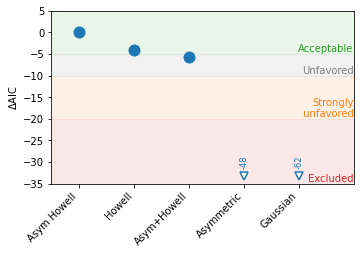

In [28]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])
xmax = 5

d_mod_comp_py   = pd.read_csv('../../../Data/tables/mass_comp/mass_df_fit-sed_comp-nobug.dat')
d_mod_comp_cons = pd.read_csv('../../../Data/tables/mass_comp/mass_df_fit_c-sed_comp-nobug.dat')
d_mod_comp_snf = pd.read_csv('../../../Data/tables/mass_comp/mass_df_snf-sed_comp-nobug.dat')

def show_results(data_, show_text=True, show_aicc=True, **kwargs):
    """ """
    if show_aicc:
        ykey = '$\Delta$ AIC'
        ylow = -35
        yscale = 'linear'
        shift = 0.95
    else:
        ykey = 'Proba'
        ylow = 1e-6
        yscale = 'log'
        shift = 1.5
    
    flag_fixed = np.asarray(data_["Fixed"], dtype="bool")
    flag_below = np.asarray(data_[ykey]<ylow, dtype="bool")
    prop = dict(marker="o", ms=10, ls="None", mew=2, zorder=8)
    prop_notfixed = {**dict(mfc="C0", mec="C0"), **kwargs}
    prop_fixed = dict(mfc="w", mec="C0")
    # above Cut
    flag = ~flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag], **{**prop, **prop_notfixed})
    flag = flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag],  **{**prop, **prop_fixed})
    # Below Cut
    propbelow = {**prop, **{"marker":"v", "mew":1.5, "ms":8}}
    flag = ~flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_notfixed})
    flag = flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_fixed})
    flag = flag_below
    if show_text:
        for i in data_.index[flag]:
            ax.text(i, ylow*shift**2, "%.0f"%data_.iloc[i][ykey] if show_aicc else "%.1e"%data_.iloc[i][ykey], 
                    rotation=90, color="C0", va="bottom", ha="center", fontsize="small")
    #axt.plot(data.index, data["AICc"])
    ax.set_yscale(yscale)
    
    if not show_aicc:
        for i in [1,2,3,4,5]:
            cut = stats.norm.pdf(i, loc=0, scale=1)*2
            ax.axhspan(1e-20, cut, color="C1", alpha=0.1)
            ax.text(xmax,cut,r"$%d\sigma$"%i,va="bottom", ha="right", color="C1")
    else:
        spanprop = dict(alpha=.10, lw=.5)
        textprop = dict(va="bottom", ha="right")
        # Between 1 and 2 \sigma
        ax.axhspan(5, -5, color="tab:green", **spanprop)
        ax.text(xmax, -5, r"Acceptable", color="tab:green", **textprop)
        # Between 2 and 3 \sigma
        ax.axhspan(-5, -10, color="tab:gray", **spanprop)
        ax.text(xmax, -10, r"Unfavored", color="tab:gray", **textprop)
        # Between 3 and 5 \sigma
        ax.axhspan(-10, -20, color="tab:orange", **spanprop)
        ax.text(xmax, -20, "Strongly\n unfavored", color="tab:orange", **textprop)
        # Between 5 and lots of \sigma
        ax.axhspan(-20, ylow, color="tab:red", **spanprop)
        ax.text(xmax, ylow, r"Excluded", color="tab:red", **textprop)
        
        if not show_aicc:
            ax.set_ylabel(r"Model Probability ($e^{0.5\Delta\mathrm{AIC}}$)")
        else:
            ax.set_ylabel(r'$\Delta\mathrm{AIC}$')
    
    return(ylow)

ylow = show_results(d_mod_comp_py)#, mfc='C4', mec='C4')
# ylow = show_results(d_mod_comp_cons, alpha=.4, show_text=False, mfc='C3', mec='C3')
# ylow = show_results(d_mod_comp_snf, alpha=.2, show_text=False)

ax.set_xticks(d_mod_comp_py.index)
ax.set_xticklabels([d_mod_comp_py.iloc[i]["Name"] for i in d_mod_comp_py.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 5)
ax.set_xlim(-0.5, xmax)

# fidleg = Line2D([0], [0], marker='o', ms=10,
#                        color='C4', linewidth=0)
# conleg = Line2D([0], [0], marker='o', ms=10,
#                        color='C3', linewidth=0)
# snfleg = Line2D([0], [0], marker='o', ms=10,
#                        color='C0', linewidth=0)

# handles = [fidleg, conleg, snfleg]
# labels = ['Fiducial', 'Cons', 'SNF']
# 
# ax.legend(handles, labels)
#           #loc='upper center', fontsize='medium', ncol=5,
#           #bbox_to_anchor=(0.5, 1.0, 0.0, 0.15))

fig.savefig('../../../Images/pdf/mass_comp-nobug.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/mass_comp-nobug.png', bbox_inches='tight', dpi=600)

FileNotFoundError: [Errno 2] No such file or directory: '../../../Data/tables/mass_comp/mass_df_fit-sed_comp.dat.dat'

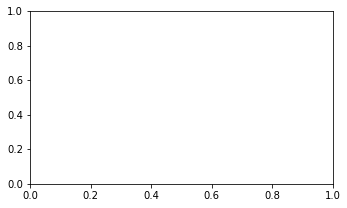

In [21]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])
xmax = 8

d_mod_comp_py   = pd.read_csv('../../../Data/tables/mass_comp/mass_df_fit-sed_comp.dat.dat')
d_mod_comp_cons = pd.read_csv('../../../Data/tables/mass_comp/df_comparaison_cons.dat')

def show_results(data_, show_text=True, show_aicc=True, **kwargs):
    """ """
    if show_aicc:
        ykey = '$\Delta$ AIC'
        ylow = -35
        yscale = 'linear'
        shift = 0.95
    else:
        ykey = 'Proba'
        ylow = 1e-6
        yscale = 'log'
        shift = 1.5
    
    flag_fixed = np.asarray(data_["Fixed"], dtype="bool")
    flag_below = np.asarray(data_[ykey]<ylow, dtype="bool")
    prop = {**dict(marker="o", ms=10, ls="None", mew=2, zorder=8),**kwargs}
    prop_notfixed = dict(mfc="C0", mec="C0")
    prop_fixed = dict(mfc="w", mec="C0")
    # above Cut
    flag = ~flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag], **{**prop, **prop_notfixed})
    flag = flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag],  **{**prop, **prop_fixed})
    # Below Cut
    propbelow = {**prop, **{"marker":"v", "mew":1.5, "ms":8}}
    flag = ~flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_notfixed})
    flag = flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_fixed})
    flag = flag_below
    if show_text:
        for i in data_.index[flag]:
            ax.text(i, ylow*shift**2, "%.0f"%data_.iloc[i][ykey] if show_aicc else "%.1e"%data_.iloc[i][ykey], 
                    rotation=90, color="C0", va="bottom", ha="center", fontsize="small")
    #axt.plot(data.index, data["AICc"])
    ax.set_yscale(yscale)
    
    if not show_aicc:
        for i in [1,2,3,4,5]:
            cut = stats.norm.pdf(i, loc=0, scale=1)*2
            ax.axhspan(1e-20, cut, color="C1", alpha=0.1)
            ax.text(xmax,cut,r"$%d\sigma$"%i,va="bottom", ha="right", color="C1")
    else:
        spanprop = dict(alpha=.05, lw=.5)
        textprop = dict(va="bottom", ha="right")
        # Between 1 and 2 \sigma
        ax.axhspan(5, -5, color="tab:green", **spanprop)
        ax.text(xmax, -5, r"Acceptable", color="tab:green", **textprop)
        # Between 2 and 3 \sigma
        ax.axhspan(-5, -10, color="tab:gray", **spanprop)
        ax.text(xmax, -10, r"Unfavored", color="tab:gray", **textprop)
        # Between 3 and 5 \sigma
        ax.axhspan(-10, -20, color="tab:orange", **spanprop)
        ax.text(xmax, -20, "Strongly\n unfavored", color="tab:orange", **textprop)
        # Between 5 and lots of \sigma
        ax.axhspan(-20, ylow, color="tab:red", **spanprop)
        ax.text(xmax, ylow, r"Excluded", color="tab:red", **textprop)
        
        if not show_aicc:
            ax.set_ylabel(r"Model Probability ($e^{0.5\Delta\mathrm{AIC}}$)")
        else:
            ax.set_ylabel(r'$\Delta\mathrm{AIC}$')
    
    return(ylow)

ylow = show_results(d_mod_comp_py, alpha=1)
ylow = show_results(d_mod_comp_py, alpha=1, show_text=False)
#ylow = show_results(d_mod_comp_cons, alpha=.4, show_text=False)

ax.set_xticks(d_mod_comp_py.index)
ax.set_xticklabels([d_mod_comp_py.iloc[i]["Name"] for i in d_mod_comp_py.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 2)
ax.set_xlim(-0.5, xmax)

fig.savefig('../../../Images/pdf/mod_comp-nocons.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/mod_comp-nocons.png', bbox_inches='tight', dpi=600)